<a href="https://colab.research.google.com/github/CopotronicRifat/Big-Data-Analytics/blob/main/ASSIGNMENT_02_RECOMMENDER_SYSTEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import packages

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
# Upload training ratings Train_ratings.txt

from google.colab import files
uploaded = files.upload()

Saving Train_ratings.txt to Train_ratings (7).txt


In [ ]:
# Preprocess training data

file_path = 'Train_ratings.txt'

# Define the column names
column_names = ['user_id', 'item_id', 'rating', 'timestamp']

# Read the text file using '::' as the delimiter
df_train = pd.read_csv(file_path, sep='::', engine='python', header=None, names=column_names)

# Display the first few rows of the DataFrame
df_train.head()

,user_id,item_id,rating,timestamp
0,1,661,3,978302109
1,1,914,3,978301968
2,1,2804,5,978300719
3,1,595,5,978824268
4,1,2398,4,978302281


In [ ]:
# Upload testing ratings (Test_ratings.txt)

from google.colab import files
uploaded = files.upload()

Saving Test_ratings.txt to Test_ratings (7).txt


In [ ]:
# Preprocess testing data

file_path = 'Test_ratings.txt'

# Define the column names
column_names = ['user_id', 'item_id', 'rating', 'timestamp']

# Read the text file using '::' as the delimiter
df_test = pd.read_csv(file_path, sep='::', engine='python', header=None, names=column_names)

# Display the first few rows of the DataFrame
df_test.head()

,user_id,item_id,rating,timestamp
0,1,2355,5,978824291
1,1,1197,3,978302268
2,1,1545,4,978824139
3,2,648,4,978299913
4,2,3030,4,978298434


In [ ]:
# Convert the data into matrix

np_test_ratings = df_test[['user_id', 'item_id', 'rating']].to_numpy()
np_train_ratings = df_train[['user_id', 'item_id', 'rating']].to_numpy()

In [ ]:
np_test_max = np_test_ratings.max(axis=0)
np_train_max = np_train_ratings.max(axis=0)

In [ ]:
# Print the total number of users
users = max(np_train_max[0],np_test_max[0])

# Print the total number of items
items = max(np_train_max[1],np_test_max[1])

In [ ]:
import numpy as np
from numpy.linalg import norm
from sklearn.metrics import mean_squared_error
import math

class LatentFactorModel:

    def __init__(self, num_items, num_users, num_factors, init_sd=0.1):
        # Initialize the model with the number of factors and random matrices P and Q.
        self.num_factors = num_factors
        self.P = np.random.uniform(low=0.0, high=math.sqrt(5/num_factors), size=(num_users, num_factors))
        self.Q = np.random.uniform(low=0.0, high=math.sqrt(5/num_factors), size=(num_items, num_factors))

    def predict(self, user_id, item_id) -> float:
        # Predict the rating for a given user and item by computing the dot product of user and item vectors.
        user_vector = self.P[user_id, :].reshape(1, self.num_factors)
        item_vector = self.Q[item_id, :].reshape(1, self.num_factors)
        return np.dot(user_vector, item_vector.T)

    def error(self, ratings):
        # Calculate the Root Mean Square Error (RMSE) between actual and predicted ratings.
        actual_ratings = []
        predicted_ratings = []

        for user_id, item_id, rating in ratings:
            predicted = self.predict(user_id, item_id)
            predicted_ratings.append(predicted)
            actual_ratings.append(rating)

        actual_ratings = np.asarray(actual_ratings, dtype=np.float32).reshape(-1, 1)
        predicted_ratings = np.asarray(predicted_ratings, dtype=np.float32).reshape(-1, 1)

        rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
        return round(rmse, 4)

    def step(self, user_id, item_id, real_rating, gamma, lambda_):
        # Update user and item vectors using stochastic gradient descent.
        user_vector = self.P[user_id, :]
        item_vector = self.Q[item_id, :]
        prediction_error = real_rating - np.dot(user_vector, item_vector.T)

        self.P[user_id, :] -= gamma * ((-1) * (prediction_error - lambda_ * user_vector))
        self.Q[item_id, :] -= gamma * ((-1) * (prediction_error * user_vector - lambda_ * item_vector))

    def cost(self, user_id, item_id, real_rating, gamma, lambda_):
        # Calculate the cost for a specific user, item, and rating using the cost function.
        user_vector = self.P[user_id, :]
        item_vector = self.Q[item_id, :]
        prediction_error = real_rating - np.dot(user_vector, item_vector.T)
        return (prediction_error**2) + (lambda_ * (norm(user_vector) + norm(item_vector)))

    def train(self, ratings, num_epochs, gamma, lambda_):
        # Train the model using stochastic gradient descent for the specified number of epochs.
        for epoch in range(num_epochs):
            total_error = 0

            for idx in np.random.permutation(len(ratings)):
                self.step(*ratings[idx], gamma, lambda_)
                total_error += self.cost(*ratings[idx], gamma, lambda_)

            yield epoch + 1, total_error


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def run_LatentFactorModel(num_factors, num_epochs, gamma, lambda_):
    """Run the LatentFactorModel using the given parameters and visualize the training progress.

    Args:
    - num_factors: Number of latent factors for the model.
    - num_epochs: Number of training epochs.
    - gamma: Learning rate for stochastic gradient descent.
    - lambda_: Regularization parameter.

    The function initializes the LatentFactorModel, trains it, and plots the training cost over epochs.

    """
    # Initialize the LatentFactorModel with the specified number of factors.
    lf = LatentFactorModel(items + 1, users + 1, num_factors)

    # Split the data into training and test datasets.
    train_ratings, test_ratings = np_train_ratings, np_test_ratings

    # Initialize arrays to store training cost and epoch numbers.
    costTr = np.zeros(num_epochs)
    num_epoch = np.arange(num_epochs)

    for epoch_num, cost in lf.train(train_ratings, num_epochs, gamma, lambda_):
        # Store the training cost for each epoch.
        costTr[epoch_num - 1] = cost

    # Plot the training cost over the epochs.
    plt.plot(num_epoch, np.array(costTr).reshape(num_epochs, 1), color='red', label='Train')
    plt.ylabel('Total cost')
    plt.xlabel('Number of Iteration')
    plt.title('Cost-Iteration plot for training')
    plt.show()

    # Calculate and print the RMSE for the test data.
    print('RMS error for test data: ' + str(lf.error(test_ratings)))

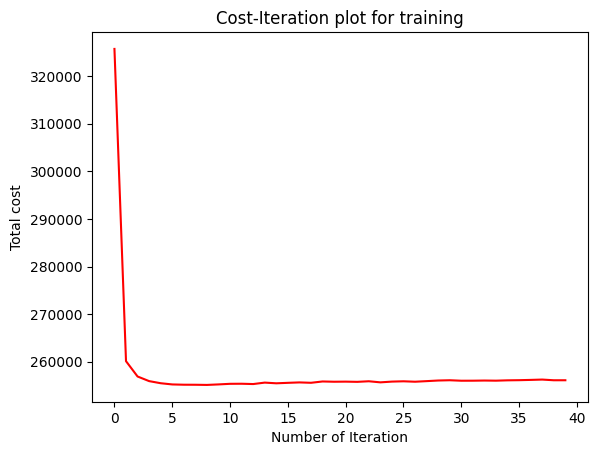

RMS error for test data: 1.3439


In [ ]:
k = 25
epoch = 40

# Regularization parameter
lambda_= 0.1

# Learning rate
gamma = 0.01
run_LatentFactorModel(k, epoch, gamma, lambda_)

The class LatentFactorModel is designed for collaborative filtering. It takes as input the number of items, users, latent factors, and an optional initialization standard deviation.

The __init__ method initializes the model with random user and item matrices (P and Q) based on the specified number of factors.

The predict method computes a prediction for the rating of a user for an item by performing a dot product between the user and item vectors.

The error method calculates the Root Mean Square Error (RMSE) between actual and predicted ratings for a given set of user-item ratings.

The step method updates the user and item vectors using stochastic gradient descent to minimize the prediction error.

The cost method computes the cost (error) for a specific user-item pair using the prediction error and regularization terms.

The train method trains the model using stochastic gradient descent for a specified number of epochs. It returns the epoch number and the total error for each epoch.

This code provides a framework for implementing collaborative filtering with matrix factorization and can be used for building recommendation systems.

In [ ]:
import numpy as np
from numpy import linalg as LA
from sklearn.metrics import mean_squared_error
from math import sqrt

def model_eval(evaluation_data_path, P, Q):
    """
    Evaluate the Latent Factor Model using the given evaluation data, P, and Q matrices, and calculate RMSE.

    Parameters:
    - evaluation_data_path: File path to the evaluation data
    - P: User-factor matrix
    - Q: Item-factor matrix

    Returns:
    - RMSE (Root Mean Squared Error)
    """

    # Load the evaluation data from the file
    evaluation_data = np.loadtxt(evaluation_data_path, delimiter=',', dtype=int)
    user_ids = evaluation_data[:, 0]
    item_ids = evaluation_data[:, 1]
    actual_ratings = evaluation_data[:, 2]

    # Initialize lists to store actual and predicted ratings
    predicted_ratings = []

    for user_id, item_id, actual_rating in zip(user_ids, item_ids, actual_ratings):
        # Predict the rating using the P and Q matrices
        user_factors = P[user_id, :]
        item_factors = Q[item_id, :]
        predicted_rating = np.dot(user_factors, item_factors)
        predicted_ratings.append(predicted_rating)

    # Calculate RMSE
    actual_array = np.asarray(actual_ratings, dtype=np.float32).reshape(-1, 1)
    predicted_array = np.asarray(predicted_ratings, dtype=np.float32).reshape(-1, 1)
    rmse = sqrt(mean_squared_error(actual_array, predicted_array))

    return rmse


Code Reference: https://github.com/rposhala/Recommender-System-on-MovieLens-dataset